In [7]:
import numpy as np
import re
import string
from collections import defaultdict
from random import shuffle, randint
import matplotlib.pyplot as plt
import heapq

In [8]:
# Preprocessing function: cleans and tokenizes text
def preprocess(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    return text.split()  # Split text into words

# Sample corpus of sentences (training data)
corpus_train = [
    "The quick brown fox jumps over the lazy dog",
    "I love natural language processing",
    "Word2Vec is a cool algorithm",
    "I enjoy learning new things"
]

# Sample validation dataset
corpus_val = [
    "Natural language processing is fun",
    "Learning new algorithms is enjoyable",
    "The lazy dog loves the quick brown fox"
]

# Preprocess the corpus: clean and tokenize each sentence
corpus_train = [preprocess(doc) for doc in corpus_train]
corpus_val = [preprocess(doc) for doc in corpus_val]

# Create a vocabulary: count occurrences of each word
vocab = defaultdict(int)
for sentence in corpus_train:
    for word in sentence:
        vocab[word] += 1

# Remove infrequent words from the vocabulary
min_count = 1
vocab = {word: count for word, count in vocab.items() if count >= min_count}

# Create word to index and index to word mappings
word_to_index = {word: idx for idx, (word, _) in enumerate(vocab.items())}
index_to_word = {idx: word for word, idx in word_to_index.items()}

In [9]:
# Huffman Tree Node
class HuffmanNode:
    def __init__(self, word, frequency):
        self.word = word
        self.frequency = frequency
        self.left = None
        self.right = None

# Build Huffman Tree and generate binary codes
def build_huffman_tree(vocab):
    heap = [[weight, [word, ""]] for word, weight in vocab.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return dict(heapq.heappop(heap)[1:])

huffman_codes = build_huffman_tree(vocab)
code_to_index = {word: [int(bit) for bit in code] for word, code in huffman_codes.items()}

In [10]:
# Initialize parameters
vocab_size = len(vocab)  # Number of unique words in the vocabulary
embedding_dim = 100  # Dimensionality of the word vectors
initial_learning_rate = 0.01  # Initial learning rate for gradient descent
beta1 = 0.9  # Decay rate for the first moment estimate
beta2 = 0.999  # Decay rate for the second moment estimate
epsilon = 1e-8  # Small constant to prevent division by zero
window_size = 2  # Context window size
dropout_rate = 0.3  # Dropout rate
patience = 3  # Early stopping patience
subsampling_threshold = 1e-5  # Subsampling threshold for frequent words
l2_lambda = 1e-4  # L2 regularization parameter
neg_samples = 5  # Number of negative samples

# Initialize weights: input-to-hidden and hidden-to-output
W1 = np.random.uniform(-0.8, 0.8, (vocab_size, embedding_dim))
W2 = np.random.uniform(-0.8, 0.8, (embedding_dim, vocab_size))

# Initialize Adam parameters
mW1 = np.zeros_like(W1)
vW1 = np.zeros_like(W1)
mW2 = np.zeros_like(W2)
vW2 = np.zeros_like(W2)

In [11]:
# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to get negative samples for a given target word
def get_negative_samples(target, vocab_size, count):
    negatives = []
    while len(negatives) < count:
        neg = randint(0, vocab_size - 1)
        if neg != target:  # Ensure the negative sample is not the target word
            negatives.append(neg)
    return negatives

# Function to apply dropout
def apply_dropout(vec, rate):
    mask = np.random.binomial(1, 1 - rate, size=vec.shape)
    return vec * mask

# Function to calculate loss for a dataset
def calculate_loss(corpus, W1, W2, word_to_index, window_size, neg_samples):
    loss = 0
    for sentence in corpus:
        sentence_indices = [word_to_index[word] for word in sentence if word in word_to_index]
        for center_pos in range(len(sentence_indices)):
            center_word_idx = sentence_indices[center_pos]
            context_indices = list(range(max(0, center_pos - window_size), min(len(sentence_indices), center_pos + window_size + 1)))
            context_indices.remove(center_pos)
            
            for context_pos in context_indices:
                context_word_idx = sentence_indices[context_pos]
                negative_samples = get_negative_samples(center_word_idx, vocab_size, neg_samples)
                sample_indices = [context_word_idx] + negative_samples

                for sample_idx in sample_indices:
                    label = 1 if sample_idx == context_word_idx else 0
                    z = np.dot(W1[center_word_idx], W2[:, sample_idx])
                    prediction = sigmoid(z)
                    loss += -np.log(prediction) if label == 1 else -np.log(1 - prediction)
    return loss

# Subsampling function
def subsample(sentence, vocab, threshold):
    total_words = sum(vocab.values())
    def keep(word):
        prob = (np.sqrt(vocab[word] / (threshold * total_words)) + 1) * (threshold * total_words) / vocab[word]
        return np.random.rand() < prob
    return [word for word in sentence if keep(word)]

# Function to calculate the hierarchical softmax
def hierarchical_softmax(center_word_idx, context_word_idx, W1, W2, huffman_codes):
    code = huffman_codes[context_word_idx]
    p = 1.0
    for bit in code:
        if bit == 0:
            p *= sigmoid(np.dot(W1[center_word_idx], W2[:, context_word_idx]))
        else:
            p *= 1 - sigmoid(np.dot(W1[center_word_idx], W2[:, context_word_idx]))
    return p

Epoch 1, Train Loss: 0, Val Loss: 262.4645166634853
Epoch 2, Train Loss: 0, Val Loss: 227.99605372033807
Epoch 3, Train Loss: 0, Val Loss: 247.63523646539088
Epoch 4, Train Loss: 0, Val Loss: 259.4308479753128
Epoch 5, Train Loss: 0, Val Loss: 220.21651784074055
Epoch 6, Train Loss: 0, Val Loss: 241.13123076489765
Epoch 7, Train Loss: 10.49277398455506, Val Loss: 252.9488340608461
Epoch 8, Train Loss: 0, Val Loss: 247.99586315982773
Early stopping at epoch 8


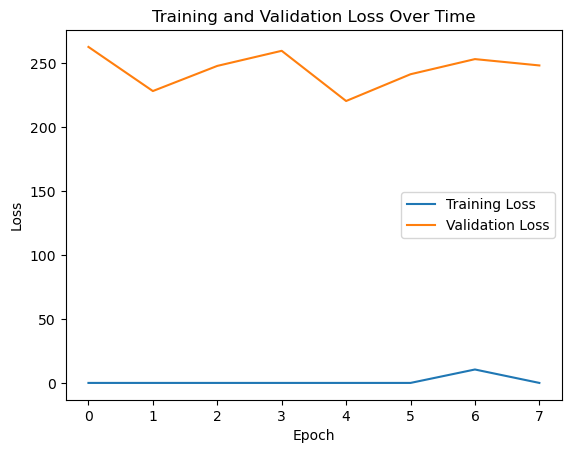

In [12]:
# Training function for the Word2Vec model with early stopping, dropout, and Adam optimizer
def train_word2vec(corpus_train, corpus_val, word_to_index, index_to_word, W1, W2, initial_learning_rate, window_size, dropout_rate, patience, subsampling_threshold, l2_lambda, neg_samples, epochs=100):
    vocab_size = len(word_to_index)
    train_loss_history = []  # List to store training loss at each epoch
    val_loss_history = []  # List to store validation loss at each epoch
    best_val_loss = float('inf')  # Initialize best validation loss
    no_improvement_epochs = 0  # Count epochs with no improvement
    
    mW1 = np.zeros_like(W1)
    vW1 = np.zeros_like(W1)
    mW2 = np.zeros_like(W2)
    vW2 = np.zeros_like(W2)
    
    for epoch in range(epochs):
        shuffle(corpus_train)  # Shuffle the corpus at the beginning of each epoch
        train_loss = 0  # Initialize training loss for the epoch
        
        for sentence in corpus_train:
            sentence = subsample(sentence, vocab, subsampling_threshold)  # Apply subsampling
            sentence_indices = [word_to_index[word] for word in sentence if word in word_to_index]
            for center_pos in range(len(sentence_indices)):
                center_word_idx = sentence_indices[center_pos]
                dynamic_window = randint(1, window_size)  # Dynamic window size
                context_indices = list(range(max(0, center_pos - dynamic_window), min(len(sentence_indices), center_pos + dynamic_window + 1)))
                context_indices.remove(center_pos)
                
                for context_pos in context_indices:
                    context_word_idx = sentence_indices[context_pos]
                    negative_samples = get_negative_samples(center_word_idx, vocab_size, neg_samples)
                    sample_indices = [context_word_idx] + negative_samples

                    for sample_idx in sample_indices:
                        label = 1 if sample_idx == context_word_idx else 0
                        z = np.dot(W1[center_word_idx], W2[:, sample_idx])
                        z = apply_dropout(z, dropout_rate)  # Apply dropout
                        prediction = sigmoid(z)
                        error = label - prediction
                        train_loss += -np.log(prediction) if label == 1 else -np.log(1 - prediction)

                        # Gradient update for weights with L2 regularization
                        dW1 = error * W2[:, sample_idx] - l2_lambda * W1[center_word_idx]
                        dW2 = error * W1[center_word_idx] - l2_lambda * W2[:, sample_idx]
                        
                        # Adam update
                        mW1[center_word_idx] = beta1 * mW1[center_word_idx] + (1 - beta1) * dW1
                        vW1[center_word_idx] = beta2 * vW1[center_word_idx] + (1 - beta2) * (dW1 ** 2)
                        mW2[:, sample_idx] = beta1 * mW2[:, sample_idx] + (1 - beta1) * dW2
                        vW2[:, sample_idx] = beta2 * vW2[:, sample_idx] + (1 - beta2) * (dW2 ** 2)

                        mW1_corr = mW1[center_word_idx] / (1 - beta1 ** (epoch + 1))
                        vW1_corr = vW1[center_word_idx] / (1 - beta2 ** (epoch + 1))
                        mW2_corr = mW2[:, sample_idx] / (1 - beta1 ** (epoch + 1))
                        vW2_corr = vW2[:, sample_idx] / (1 - beta2 ** (epoch + 1))

                        W1[center_word_idx] += initial_learning_rate * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
                        W2[:, sample_idx] += initial_learning_rate * mW2_corr / (np.sqrt(vW2_corr) + epsilon)

        train_loss_history.append(train_loss)  # Append training loss for the current epoch
        val_loss = calculate_loss(corpus_val, W1, W2, word_to_index, window_size, neg_samples)
        val_loss_history.append(val_loss)  # Append validation loss for the current epoch
        
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
    
    return train_loss_history, val_loss_history

# Train the Word2Vec model with early stopping, dropout, and Adam optimizer, and get the loss history
train_loss_history, val_loss_history = train_word2vec(corpus_train, corpus_val, word_to_index, index_to_word, W1, W2, initial_learning_rate, window_size, dropout_rate, patience, subsampling_threshold, l2_lambda, neg_samples, epochs=100)

# Plot the loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [13]:
# Get the word vector for a specific word
def get_word_vector(word):
    return W1[word_to_index[word]]

# Test the word vector retrieval
word = "love"
print(f"Vector for '{word}': {get_word_vector(word)}")

# Function to find similar words to a given word
def find_similar_words(word, top_n=5):
    word_vector = get_word_vector(word)
    similarities = {}
    for other_word in word_to_index:
        if other_word == word:
            continue
        other_word_vector = get_word_vector(other_word)
        # Cosine similarity between word vectors
        similarity = np.dot(word_vector, other_word_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(other_word_vector))
        similarities[other_word] = similarity
    # Sort words by similarity and return the top_n most similar words
    similar_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return similar_words[:top_n]

# Find and print similar words to "love"
similar_words = find_similar_words("love")
print(f"Words similar to 'love': {similar_words}")

Vector for 'love': [ 0.20871956 -0.07473509 -0.16238012 -0.38504451  0.27238079  0.26280869
 -0.37285904 -0.08056838  0.08688025  0.39884085  0.24560399 -0.74734314
  0.45208502 -0.16298109  0.00554291  0.66083364  0.63127728 -0.33742989
  0.73244005 -0.1876202  -0.02194767  0.20020119  0.03603942 -0.0896649
  0.65416045 -0.7391692   0.78052686 -0.16494725 -0.35298202  0.46028151
  0.27374439  0.4713153   0.66783191  0.59635373 -0.49638703  0.27224108
  0.51651247 -0.1469468   0.11945211  0.21014438  0.22873824  0.1794927
 -0.28594845  0.45418692  0.06264154 -0.52553192 -0.64007143 -0.28448639
  0.5636837  -0.28934482 -0.132792    0.62534404 -0.62437416  0.53578612
  0.03268135  0.73729668  0.01269159 -0.52267902  0.43998925 -0.76117994
  0.35283727 -0.11299093  0.00442502  0.21516336 -0.06496171 -0.36811723
  0.64322941  0.09325391 -0.00633598 -0.11805265  0.76403511  0.47716802
  0.3984372   0.53311143  0.06971541 -0.61217626  0.67761471 -0.181725
 -0.77708373 -0.30955684 -0.06085929

## Evaluation

In [14]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Example usage:
word1 = "king"
word2 = "queen"
vector1 = get_word_vector(word1)
vector2 = get_word_vector(word2)
similarity = cosine_similarity(vector1, vector2)
print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity}")

KeyError: 'king'

In [ ]:
def evaluate_analogy(word1, word2, word3, word4, top_n=5):
    # word1 is to word2 as word3 is to ?
    vec1 = get_word_vector(word1)
    vec2 = get_word_vector(word2)
    vec3 = get_word_vector(word3)
    
    target_vec = vec2 - vec1 + vec3
    similarities = {}
    
    for word in word_to_index:
        if word in {word1, word2, word3}:
            continue
        word_vec = get_word_vector(word)
        similarity = cosine_similarity(target_vec, word_vec)
        similarities[word] = similarity
    
    sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    predicted_words = [word for word, _ in sorted_similarities[:top_n]]
    
    return predicted_words

# Example usage:
word1 = "king"
word2 = "man"
word3 = "queen"
word4 = "woman"  # Expected answer
predicted_words = evaluate_analogy(word1, word2, word3, word4)
print(f"Predicted words for '{word1}' is to '{word2}' as '{word3}' is to ?: {predicted_words}")

In [ ]:
def evaluate_word_similarity(pairs):
    similarities = []
    for word1, word2 in pairs:
        vec1 = get_word_vector(word1)
        vec2 = get_word_vector(word2)
        similarity = cosine_similarity(vec1, vec2)
        similarities.append((word1, word2, similarity))
    return similarities

# Example usage:
similarity_pairs = [("king", "queen"), ("man", "woman"), ("car", "bus")]
similarities = evaluate_word_similarity(similarity_pairs)
for word1, word2, similarity in similarities:
    print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity}")

In [ ]:
def evaluate_model(word_pairs, analogy_tasks, top_n=5):
    results = {
        "cosine_similarity": [],
        "analogy": []
    }
    
    # Evaluate Cosine Similarity
    for word1, word2 in word_pairs:
        vec1 = get_word_vector(word1)
        vec2 = get_word_vector(word2)
        similarity = cosine_similarity(vec1, vec2)
        results["cosine_similarity"].append((word1, word2, similarity))
    
    # Evaluate Analogy Tasks
    for word1, word2, word3, expected in analogy_tasks:
        predicted_words = evaluate_analogy(word1, word2, word3, expected, top_n=top_n)
        results["analogy"].append((word1, word2, word3, expected, predicted_words))
    
    return results

# Example usage:
word_pairs = [("king", "queen"), ("man", "woman"), ("car", "bus")]
analogy_tasks = [("king", "man", "queen", "woman"), ("Paris", "France", "Berlin", "Germany")]
results = evaluate_model(word_pairs, analogy_tasks)

# Output results
for word1, word2, similarity in results["cosine_similarity"]:
    print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity}")
    
for word1, word2, word3, expected, predicted in results["analogy"]:
    print(f"Analogy: '{word1}' is to '{word2}' as '{word3}' is to '{expected}' - Predicted: {predicted}")